In [43]:
#######################################################################
# Copyright (C)                                                       #
# 2016 Shangtong Zhang(zhangshangtong.cpp@gmail.com)                  #
# 2016 Kenta Shimada(hyperkentakun@gmail.com)                         #
# Permission given to modify the code as long as you keep this        #
# declaration at the top                                              #
#######################################################################

from __future__ import print_function
import numpy as np
from TileCoding import *
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# possible priorities
PRIORITIES = np.arange(0, 4)
# reward for each priority
REWARDS = np.power(2, np.arange(0, 4))

# possible actions
REJECT = 0
ACCEPT = 1
ACTIONS = [REJECT, ACCEPT]

# total number of servers
NUM_OF_SERVERS = 10

# at each time step, a busy server will be free w.p. 0.06
PROBABILITY_FREE = 0.06

# step size for learning state-action value
ALPHA = 0.01

# step size for learning average reward
BETA = 0.01

# probability for exploration
EPSILON = 0.1

# a wrapper class for differential semi-gradient Sarsa state-action function
class ValueFunction:
    # In this example I use the tiling software instead of implementing standard tiling by myself
    # One important thing is that tiling is only a map from (state, action) to a series of indices
    # It doesn't matter whether the indices have meaning, only if this map satisfy some property
    # View the following webpage for more information
    # http://incompleteideas.net/sutton/tiles/tiles3.html
    # @alpha: step size for learning state-action value
    # @beta: step size for learning average reward
    def __init__(self, numOfTilings, alpha=ALPHA, beta=BETA):
        self.numOfTilings = numOfTilings
        self.maxSize = 2048
        self.hashTable = IHT(self.maxSize)
        self.weights = np.zeros(self.maxSize)

        # state features needs scaling to satisfy the tile software
        self.serverScale = self.numOfTilings / float(NUM_OF_SERVERS)
        self.priorityScale = self.numOfTilings / float(len(PRIORITIES) - 1)

        self.averageReward = 0.0

        # divide step size equally to each tiling
        self.alpha = alpha / self.numOfTilings

        self.beta = beta

    # get indices of active tiles for given state and action
    def getActiveTiles(self, freeServers, priority, action):
        activeTiles = tiles(self.hashTable, self.numOfTilings,
                            [self.serverScale * freeServers, self.priorityScale * priority],
                            [action])
#         print("active tiles for {}-{}-{}: {}".format(freeServers, priority, action, activeTiles))
        return activeTiles

    # estimate the value of given state and action without subtracting average
    def value(self, freeServers, priority, action):
        activeTiles = self.getActiveTiles(freeServers, priority, action)
        return np.sum(self.weights[activeTiles])

    # estimate the value of given state without subtracting average
    def stateValue(self, freeServers, priority):
        values = [self.value(freeServers, priority, action) for action in ACTIONS]
        # if no free server, can't accept
        if freeServers == 0:
            return values[REJECT]
        return np.max(values)

    # learn with given sequence
    def learn(self, freeServers, priority, action, newFreeServers, newPriority, newAction, reward):
        activeTiles = self.getActiveTiles(freeServers, priority, action)
#         estimation = np.sum(self.weights[activeTiles])
        estimation = self.value(freeServers, priority, action)
        delta = reward - self.averageReward + self.value(newFreeServers, newPriority, newAction) - estimation
        # update average reward
        self.averageReward += self.beta * delta
        delta *= self.alpha
        for activeTile in activeTiles:
            self.weights[activeTile] += delta

# get action based on epsilon greedy policy and @valueFunction
def getAction(freeServers, priority, valueFunction):
    # if no free server, can't accept
    if freeServers == 0:
        return REJECT
    if np.random.binomial(1, EPSILON) == 1:
        return np.random.choice(ACTIONS)
    values = [valueFunction.value(freeServers, priority, action) for action in ACTIONS]
    return np.random.choice([action_ for action_, value_ in enumerate(values) if value_ == np.max(values)])

# take an action
def takeAction(freeServers, priority, action):
    if freeServers > 0 and action == ACCEPT:
        freeServers -= 1
    reward = REWARDS[priority] * action
    # some busy servers may become free
    busyServers = NUM_OF_SERVERS - freeServers
    freeServers += np.random.binomial(busyServers, PROBABILITY_FREE)
    return freeServers, np.random.choice(PRIORITIES), reward

# differential semi-gradient Sarsa
# @valueFunction: state value function to learn
# @maxSteps: step limit in the continuing task
def differentialSemiGradientSarsa(valueFunction, maxSteps):
    currentFreeServers = NUM_OF_SERVERS
    currentPriority = np.random.choice(PRIORITIES)
    currentAction = getAction(currentFreeServers, currentPriority, valueFunction)
    step = 0
    # track the hit for each number of free servers
    freq = np.zeros(NUM_OF_SERVERS + 1)
    while step < maxSteps:
        if step % 100 == 0:
            print('step:', step, 'average reward:', valueFunction.averageReward)
        step += 1
        freq[currentFreeServers] += 1
        newFreeServers, newPriority, reward = takeAction(currentFreeServers, currentPriority, currentAction)
        newAction = getAction(newFreeServers, newPriority, valueFunction)
        valueFunction.learn(currentFreeServers, currentPriority, currentAction,
                            newFreeServers, newPriority, newAction, reward)
        currentFreeServers = newFreeServers
        currentPriority = newPriority
        currentAction = newAction
    print('Frequency of number of free servers:')
    print(freq / maxSteps)

In [10]:
%matplotlib inline

step: 0 average reward: 0.0
step: 100 average reward: 1.447883326731271
step: 200 average reward: 2.1112117814797964
step: 300 average reward: 2.3142923100310835
step: 400 average reward: 2.320315645475371
step: 500 average reward: 2.5440873365621037
step: 600 average reward: 1.9774862807197053
step: 700 average reward: 2.289035269785268
step: 800 average reward: 2.5495301757001636
step: 900 average reward: 2.5676123771456347
Frequency of number of free servers:
[0.333 0.341 0.182 0.07  0.039 0.021 0.006 0.004 0.002 0.001 0.001]
Policy (0 Reject, 1 Accept)
[[0. 1. 1. 1. 0. 1. 1. 1. 0. 0. 0.]
 [0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
 [0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]]


Text(0.5,0,'Action')

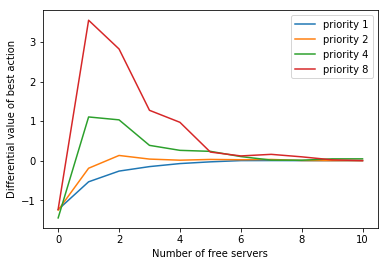

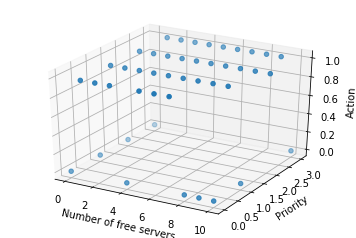

In [44]:
maxSteps = int(1000)
# use tile coding with 8 tilings
numOfTilings = 8
valueFunction = ValueFunction(numOfTilings)
differentialSemiGradientSarsa(valueFunction, maxSteps)
values = np.zeros((len(PRIORITIES), NUM_OF_SERVERS + 1))
for priority in PRIORITIES:
    for freeServers in range(NUM_OF_SERVERS + 1):
        values[priority, freeServers] = valueFunction.stateValue(freeServers, priority)

plt.figure(0)
for priority in PRIORITIES:
    plt.plot(range(NUM_OF_SERVERS + 1), values[priority, :], label='priority ' + str(REWARDS[priority]))
plt.xlabel('Number of free servers')
plt.ylabel('Differential value of best action')
plt.legend()

fig = plt.figure(1)
ax = fig.add_subplot(111, projection='3d')
axisX, axisY = np.meshgrid(np.arange(0, NUM_OF_SERVERS + 1), PRIORITIES)
axisZ = np.zeros(axisX.shape)
for priority in PRIORITIES:
    for freeServers in range(NUM_OF_SERVERS + 1):
        values = [valueFunction.value(freeServers, priority, action) for action in ACTIONS]
        if freeServers == 0:
            axisZ[priority, freeServers] = REJECT
        else:
            axisZ[priority, freeServers] = np.argmax(values)
print('Policy (0 Reject, 1 Accept)')
print(axisZ)
ax.scatter(axisX, axisY, axisZ)
ax.set_xlabel('Number of free servers')
ax.set_ylabel('Priority')
ax.set_zlabel('Action')

In [45]:
for i in range(10):
    for priority in PRIORITIES:
        print(valueFunction.value(i, priority, 1))

-0.12615991637888735
-0.05989937961816373
0.22776879165965222
0.765327398050657
-0.5353643788389796
-0.1924265623771314
1.1041552933523608
3.54930751870272
-0.2646168009360168
0.13058247275041485
1.0308440084923678
2.822579879190863
-0.15132500864832993
0.03895498950205647
0.38593476349317263
1.2722631456845073
-0.08045327021297424
0.010943761098847185
0.25989486732128875
0.9688550159848718
-0.030726225775073123
0.02994984761887305
0.23451838765986477
0.21651093701053586
0.00039990572157076916
0.022483774353115646
0.10263852678949695
0.11863200864595644
0.0017717765147788741
0.02961118598192598
0.013180948643695825
0.15871292568870177
0.0
0.0034258026442329495
0.0098875
0.09600767324977103
0.0
0.0
0.044550000000000006
0.01980311375
